# Generate Training/Testing Data (normal distribution)

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import torch 
import sklearn
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn


In [2]:
sampled_data = []
matching_parameters = []
MIN_N = 10e2
MAX_N = 10e3
MAX_MEAN = 10000
MAX_SD = 1000

for i in range(0,100000):
    n = np.random.randint(MIN_N, MAX_N)
    mean = np.random.randint(0, MAX_MEAN)/100.0
    sd = np.random.randint(0,MAX_SD)/100.0
    values = np.random.normal(mean, sd, n)
    sampled_data.append(values)
    matching_parameters.append([mean, sd, n])
    

(array([1., 0., 0., ..., 0., 0., 1.]),
 array([ 54.71165368,  54.72426505,  54.73687642, ..., 118.2981812 ,
        118.31079257, 118.32340394]),
 <BarContainer object of 5044 artists>)

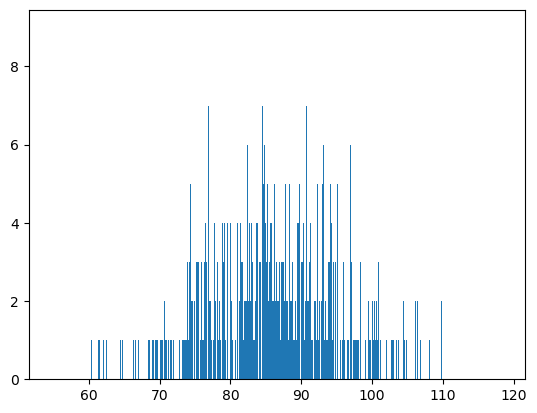

In [3]:
plt.hist(sampled_data[0],matching_parameters[0][2])

## Summary Stats

In [4]:
summary_stats = []
for i in range(0,len(sampled_data)):
    #take elementwise average of each sample distribution
    summary = []        # will contain [average, n]
    summary.append(np.sum(sampled_data[i])/matching_parameters[i][2])
    summary.append(matching_parameters[i][2])
    
    #predict mean first, remove irrelevant parameters
    matching_parameters[i].pop(0)
    matching_parameters[i].pop(1)
    summary_stats.append(summary)

## Split into test & train data

In [5]:
x,y = np.array(summary_stats), np.array(matching_parameters)
y = y.reshape(-1,1)
x_scaler = MinMaxScaler()
x_scaled = x_scaler.fit_transform(x)
y_scaler = MinMaxScaler()
y_scaled = y_scaler.fit_transform(y)

In [6]:
x_train, x_test, y_train, y_test = train_test_split(x_scaled, y_scaled, test_size=0.33, random_state=42)

In [7]:
X_train = torch.from_numpy(x_train.astype(np.float32))
Y_train = torch.from_numpy(y_train.astype(np.float32))
X_test = torch.from_numpy(x_test.astype(np.float32))
Y_test = torch.from_numpy(y_test.astype(np.float32))


In [8]:
class Data(Dataset):
  def __init__(self, X: np.ndarray, y: np.ndarray) -> None:
    self.X = torch.from_numpy(X.astype(np.float32))
    self.y = torch.from_numpy(y.astype(np.float32))
    self.len = self.X.shape[0]
    
  def __getitem__(self, index: int) -> tuple:
    return self.X[index], self.y[index]

  def __len__(self) -> int:
        return self.len

In [9]:
train_data = Data(x_train, y_train)
test_data = Data(x_test, y_test)

In [10]:
print(train_data[1])

(tensor([0.9801, 0.5374]), tensor([0.6476]))


In [11]:
batch_size = 10
num_workers = 4

#load data
train_loader = DataLoader(train_data, 
                         batch_size=batch_size, 
                         shuffle=True, 
                         num_workers=num_workers)

## Linear Regression

In [12]:
class LinearRegression(nn.Module):
  def __init__(self, input_dim: int, 
               hidden_dim: int, output_dim: int) -> None:
    super(LinearRegression, self).__init__()
    self.input_to_hidden = nn.Linear(input_dim, hidden_dim)
    self.hidden_layer_1 = nn.Linear(hidden_dim, hidden_dim)
    self.hidden_layer_2 = nn.Linear(hidden_dim, hidden_dim)
    self.hidden_to_output = nn.Linear(hidden_dim, output_dim)
  def forward(self, x: torch.Tensor) -> torch.Tensor:
    x = self.input_to_hidden(x)
    x = self.hidden_layer_1(x)
    x = self.hidden_layer_2(x)
    x = self.hidden_to_output(x)
    return x

In [13]:
input_dim = x_train.shape[1]
hidden_dim = 2
model = LinearRegression(input_dim, hidden_dim, 1)


In [14]:
print(model)

LinearRegression(
  (input_to_hidden): Linear(in_features=2, out_features=2, bias=True)
  (hidden_layer_1): Linear(in_features=2, out_features=2, bias=True)
  (hidden_layer_2): Linear(in_features=2, out_features=2, bias=True)
  (hidden_to_output): Linear(in_features=2, out_features=1, bias=True)
)


## Loss function & Optimiser

In [15]:
loss_func = nn.MSELoss()
optimizer = torch.optim.SGD(model.parameters(), lr=0.1)

## Trainning

In [27]:
e = []
l = []
from torchviz import make_dot
for epoch in range(0,500):  
    predict_y = model(X_train) 
    loss = loss_func(predict_y, Y_train) 
    #make_dot(predict_y).render("attached", format="png")
    optimizer.zero_grad() 
    loss.backward() 

    optimizer.step() 
    print('epoch {}, loss function {}'.format(epoch, loss.item()))
    e.append(epoch)
    l.append(loss.item())
    

epoch 0, loss function 0.08385401219129562


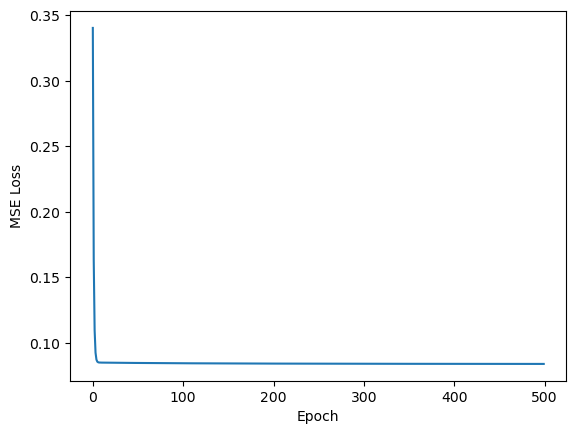

In [17]:
plt.plot(np.array(e), np.array(l))
plt.xlabel("Epoch")
plt.ylabel("MSE Loss")
plt.show()

In [18]:
PATH = './normal_model.pth'
torch.save(model.state_dict(), PATH)

## Testing trained model

In [19]:
model = LinearRegression(input_dim, hidden_dim, 1)
model.load_state_dict(torch.load(PATH))

<All keys matched successfully>

In [20]:
test_loader = DataLoader(test_data, batch_size=batch_size, 
                        shuffle=True, num_workers=num_workers)

In [21]:
with torch.no_grad():
    loss = 0
    predictions = model(X_test)
    labels = torch.from_numpy(y_scaler.inverse_transform(Y_test))
    predictions = torch.from_numpy(y_scaler.inverse_transform(predictions))
    loss += nn.functional.mse_loss(predictions, labels)
    print(f'MSE Loss: {loss / (i + 1):.5f}')

MSE Loss: 0.00008
